In [1]:
from analysis.load_dataset import build_tg_data
import numpy as np
import torch
import pandas as pd
import torch_geometric as tg
import torch.nn.functional as F
from sklearn import metrics
from torch_geometric.nn import TransformerConv
from torch_geometric.utils import to_networkx, from_networkx


import networkx as nx
import matplotlib.pyplot as plt


/users/Min/miniconda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def evaluate(y_truth,y_pred):
    auc = metrics.roc_auc_score(y_truth, y_pred, multi_class='ovo',labels=[0,1],average='macro')
    ap = metrics.average_precision_score(y_truth, y_pred, average='macro', pos_label=1, sample_weight=None)
    return ap,auc
def process_data(data,max_time_steps=32):
    data.edge_time = data.edge_time-data.edge_time.min() #process edge time
    data.edge_time = data.edge_time/data.edge_time.max()
    data.edge_time = (data.edge_time*max_time_steps).long()
    data.edge_time = data.edge_time.view(-1,1).float()
    
    
    edge = torch.cat([data.edge_index,data.edge_time.view(1,-1)],dim=0) #process node time
    degree = pd.DataFrame(edge.T.numpy()).groupby(0).min().values
    ids = pd.DataFrame(data.edge_index.T.numpy()).groupby(0).count().index.values 
    key = {}
    for i in range(data.x.shape[0]):
        key[i]=0
    for i in range(len(ids)):
        key[ids[i]]=degree[i][1]
    node_time = np.array(list(key.values()))
    data.node_time=torch.tensor(node_time)
    
    # trans to undirected graph
    data.edge_index = torch.cat((data.edge_index,data.edge_index[[1,0],:]),dim=1)
    data.edge_time = torch.cat((data.edge_time,data.edge_time),dim=0)

    return data

In [3]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='data', name='Cora')
data = dataset[0]
nlabels = dataset.num_classes
device = torch.device('cpu')
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [4]:
labels = data.y
# 获取每个标签对应的节点索引
label_indices = {}
unique_labels = labels.unique()

for label in unique_labels:
    label_indices[label.item()] = torch.nonzero(labels == label).view(-1)

# 打印每个标签对应的节点索引
for label, indices in label_indices.items():
    print(f"Label {label}: Node indices {indices}, shape {indices.shape}")

Label 0: Node indices tensor([   3,    6,   10,   11,   32,   35,   52,   60,   61,   62,   65,   74,
          79,   80,   81,   88,   94,   95,   98,  100,  142,  146,  149,  161,
         164,  186,  195,  204,  211,  214,  239,  242,  257,  260,  270,  274,
         276,  279,  280,  292,  304,  305,  315,  323,  324,  334,  347,  354,
         365,  373,  405,  408,  415,  423,  434,  437,  440,  446,  456,  461,
         467,  475,  478,  485,  496,  497,  502,  525,  527,  530,  531,  543,
         544,  572,  586,  591,  606,  614,  619,  624,  636,  642,  651,  659,
         666,  667,  679,  680,  693,  707,  711,  717,  718,  725,  730,  731,
         733,  734,  736,  738,  751,  753,  763,  767,  769,  771,  777,  794,
         809,  815,  838,  839,  842,  851,  852,  858,  861,  863,  873,  880,
         888,  895,  897,  901,  917,  948,  964,  965,  966,  975,  989,  992,
        1006, 1008, 1013, 1025, 1036, 1042, 1047, 1058, 1069, 1078, 1079, 1083,
        1104, 1110

In [7]:
class0, class1, class2, class3, class4, class5, class6 = label_indices[0], label_indices[1], label_indices[2], label_indices[3], label_indices[4], label_indices[5], label_indices[6]

class0.shape, class1.shape, class2.shape, class3.shape, class4.shape, class5.shape, class6.shape

(torch.Size([351]),
 torch.Size([217]),
 torch.Size([418]),
 torch.Size([818]),
 torch.Size([426]),
 torch.Size([298]),
 torch.Size([180]))

In [8]:
labels, labels.shape

(tensor([3, 4, 4,  ..., 3, 3, 3]), torch.Size([2708]))

In [9]:
g = to_networkx(data, to_undirected=True)
g

In [10]:
list(g.nodes())[:5]

[0, 1, 2, 3, 4]

In [11]:
class0_l = list(class0.numpy().tolist())
class1_l = list(class1.numpy().tolist())
class2_l = list(class2.numpy().tolist())
class3_l = list(class3.numpy().tolist())
class4_l = list(class4.numpy().tolist())
class5_l = list(class5.numpy().tolist())
class6_l = list(class6.numpy().tolist())
class0_l[:10]

[3, 6, 10, 11, 32, 35, 52, 60, 61, 62]

#### 局部子图结构分析

In [12]:
ego_g = nx.ego_graph(g, 0, radius=3)
nx.constraint(ego_g)

{0: 0.48225308641975306,
 13: 1.0,
 532: 0.8193024105186268,
 2582: 0.482253086419753,
 24: 0.6017255994733473,
 1052: 1.0,
 547: 1.0,
 563: 0.6727132537943348,
 1075: 1.0,
 1100: 1.0,
 1636: 0.7012468549630713,
 633: 0.47524551578605634,
 1665: 1.0,
 1166: 0.5,
 143: 1.0,
 664: 1.0,
 157: 0.7012468549630713,
 158: 1.0,
 1701: 0.01984959621783947,
 699: 1.0,
 1212: 1.0,
 201: 0.4227763799835872,
 205: 0.8193024105186268,
 215: 0.5,
 216: 1.0,
 729: 1.0,
 1241: 1.0,
 226: 1.0,
 231: 0.5493799204610015,
 232: 0.3644513432351271,
 235: 1.0,
 767: 1.0,
 261: 0.8193024105186268,
 1799: 1.0,
 784: 1.0,
 1299: 1.0,
 1820: 0.7012468549630713,
 1323: 1.0,
 1334: 1.0,
 1846: 0.8193024105186268,
 1337: 0.7012468549630713,
 1852: 1.0,
 1853: 1.0,
 318: 0.7012468549630713,
 1854: 1.0,
 1855: 1.0,
 1856: 1.0,
 1857: 1.0,
 1858: 1.0,
 1859: 0.5,
 1860: 1.0,
 1862: 0.3472222222222222,
 1861: 1.0,
 1863: 0.8193024105186268,
 1864: 0.5746201607012417,
 1866: 0.7012468549630713,
 1865: 1.0,
 1867: 0.8193

In [13]:
from numba import jit
from tqdm import tqdm

@jit
def ego_ana(g, ego_nodes, radius=3):
    ego_feats = []
    
    for node in tqdm(ego_nodes):
        ego_size = []
        ego_avg_deg = []
        ego_clu = []
        ego_con = []
        
        ego_subgraph = nx.ego_graph(g, node, radius)
        ego_size.append(len(ego_subgraph))
        ego_avg_deg.append(sum(list(dict(ego_subgraph.degree()).values()))/len(ego_subgraph))
        ego_clu.append(sum(list(nx.clustering(ego_subgraph).values()))/len(ego_subgraph))
        ego_con.append(sum(list(nx.constraint(ego_subgraph).values()))/len(ego_subgraph))

        ego_feats.append(ego_size)
        ego_feats.append(ego_avg_deg)
        ego_feats.append(ego_clu)
        ego_feats.append(ego_con)
    
    ego_feats = np.array(ego_feats)
    ego_feats = ego_feats/ego_feats.max(axis=0)

    return torch.tensor(ego_feats)


/tmp/ipykernel_4156646/4153053691.py:4: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


In [15]:
class0_ego_feats = ego_ana(g, class0_l[:10], radius=3)
class0_ego_feats, class0_ego_feats.shape

 20%|██        | 2/10 [00:00<00:00,  8.05it/s]

100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


(tensor([[1.3423e-02],
         [6.7114e-03],
         [0.0000e+00],
         [6.7114e-03],
         [8.4564e-01],
         [2.4928e-02],
         [1.6500e-03],
         [3.4888e-03],
         [9.9329e-01],
         [2.3943e-02],
         [3.1563e-03],
         [4.5720e-03],
         [5.2349e-01],
         [2.1683e-02],
         [1.8374e-03],
         [4.1746e-03],
         [8.5235e-01],
         [2.3886e-02],
         [1.4339e-03],
         [3.7294e-03],
         [2.0134e-01],
         [1.6555e-02],
         [9.4226e-04],
         [4.9517e-03],
         [6.8456e-01],
         [2.5530e-02],
         [2.4350e-03],
         [3.7880e-03],
         [7.7181e-01],
         [2.1710e-02],
         [1.9568e-03],
         [4.1294e-03],
         [1.0000e+00],
         [2.2702e-02],
         [1.3524e-03],
         [3.6487e-03],
         [2.0805e-01],
         [1.8186e-02],
         [3.2216e-03],
         [4.9480e-03]], dtype=torch.float64),
 torch.Size([40, 1]))

In [16]:
class1_ego_feats = ego_ana(g, class1_l[:10], radius=3)
class1_ego_feats, class1_ego_feats.shape

100%|██████████| 10/10 [00:31<00:00,  3.17s/it]


(tensor([[2.0676e-01],
         [6.2710e-03],
         [5.0559e-04],
         [6.3411e-04],
         [2.4865e-01],
         [5.9929e-03],
         [4.7693e-04],
         [6.7434e-04],
         [1.6757e-01],
         [3.6399e-03],
         [4.6114e-04],
         [1.0887e-03],
         [2.7027e-02],
         [3.2432e-03],
         [3.1145e-04],
         [9.9166e-04],
         [4.5676e-01],
         [5.5813e-03],
         [3.7597e-04],
         [7.2862e-04],
         [3.5676e-01],
         [6.0401e-03],
         [3.6231e-04],
         [6.4059e-04],
         [6.7568e-02],
         [3.7297e-03],
         [4.4076e-04],
         [9.9163e-04],
         [1.0000e+00],
         [5.3470e-03],
         [4.6829e-04],
         [7.6833e-04],
         [3.6622e-01],
         [5.9838e-03],
         [3.7716e-04],
         [6.5049e-04],
         [1.8784e-01],
         [6.2220e-03],
         [5.6054e-04],
         [6.6791e-04]], dtype=torch.float64),
 torch.Size([40, 1]))

In [19]:


def ego_plot(g, ego_nodes, radius):

    # 设置子图的行和列
    num_rows = 3
    num_cols = 3

    # 创建一个新的图形
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))

    for i, node in enumerate(ego_nodes):
        # 计算子图在图中的位置
        row = i // num_cols
        col = i % num_cols

        ego_subgraph = nx.ego_graph(g, node, radius)

        # 创建一个节点标签的字典，设置橙色、绿色和红色的节点
        node_colors = ['red' if n in class0_l else 'orange' if n in class1_l else 'yellow' if n in class2_l else 'green' if n in class3_l else 'cyan' if n in class4_l else 'blue' if n in class5_l else 'purple' for n in ego_subgraph.nodes()]

        # 使用布局算法绘制ego子图
        pos = nx.spring_layout(ego_subgraph)
        
        # 绘制ego子图到相应的子图位置
        nx.draw(ego_subgraph, pos, with_labels=True, node_size=120, ax=axes[row, col], node_color=node_colors, font_size=5)
        
        # 设置标题
        axes[row, col].set_title(f'Ego Subgraph for Node {node}')

    # 调整子图之间的间距
    plt.tight_layout()

    # 显示图
    plt.show()


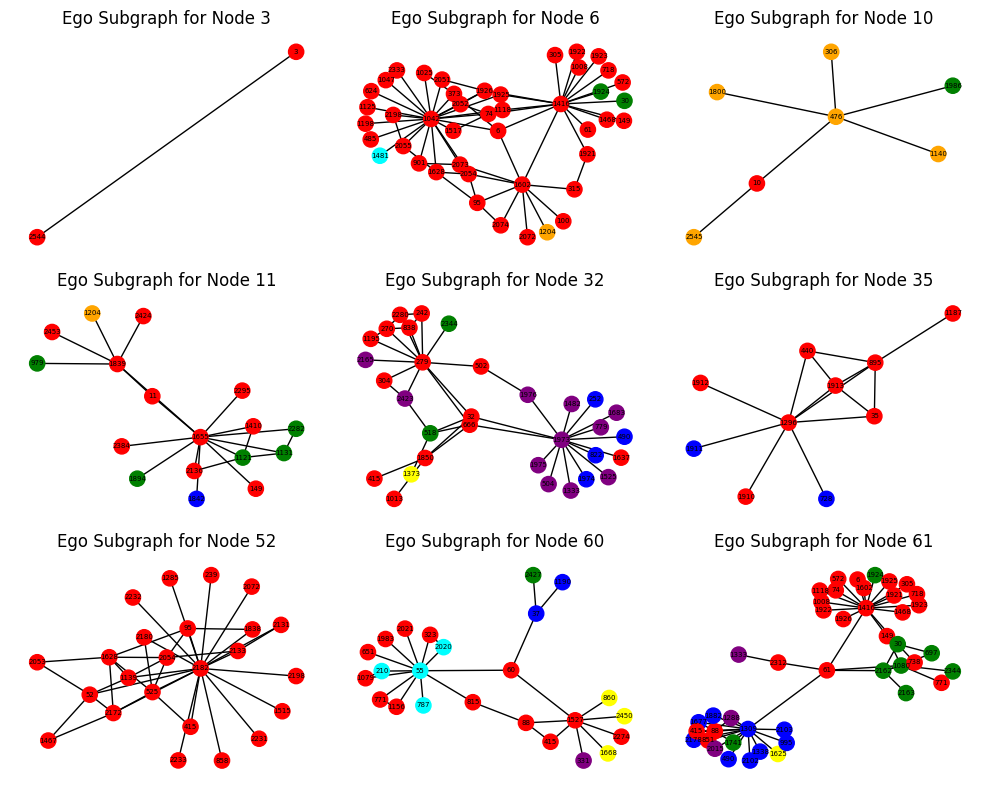

In [20]:
ego_plot(g, class0_l[:9], radius=2)

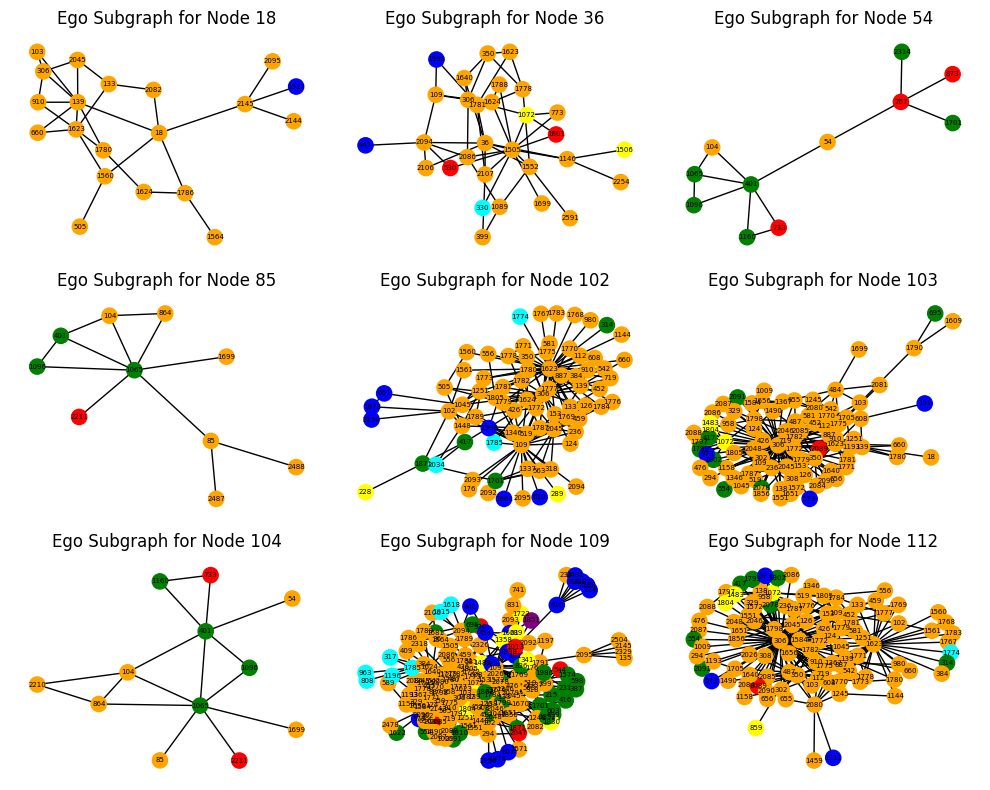

In [21]:
ego_plot(g, class1_l[:9], radius=2)

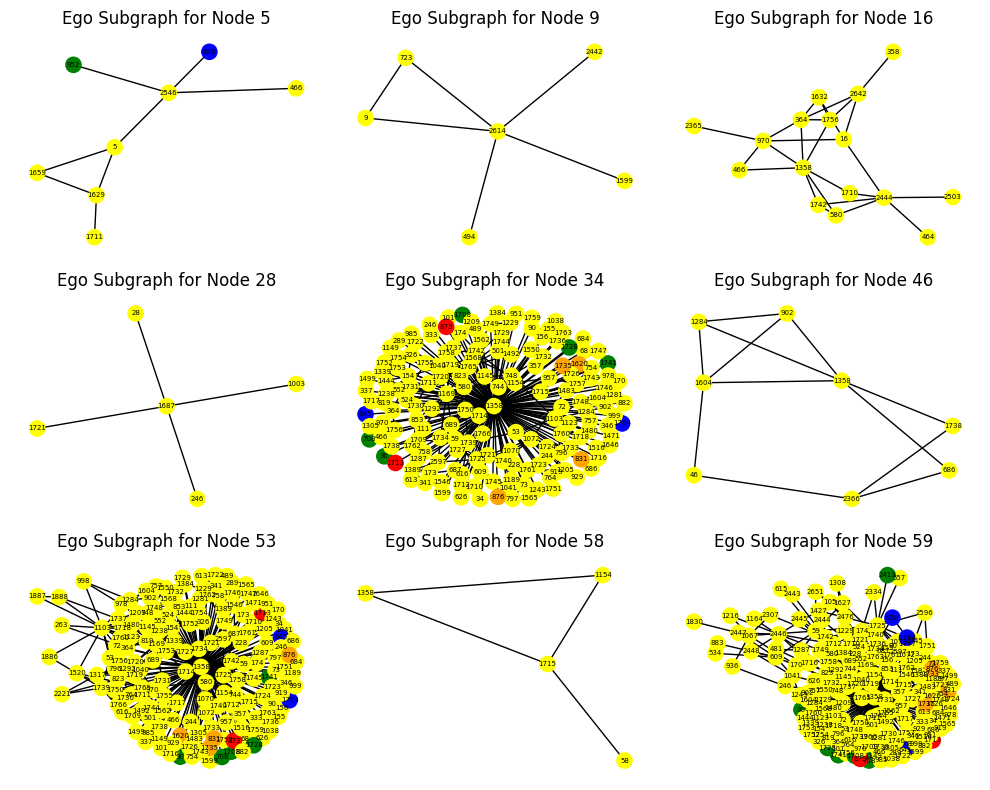

In [22]:
ego_plot(g, class2_l[:9], radius=2)

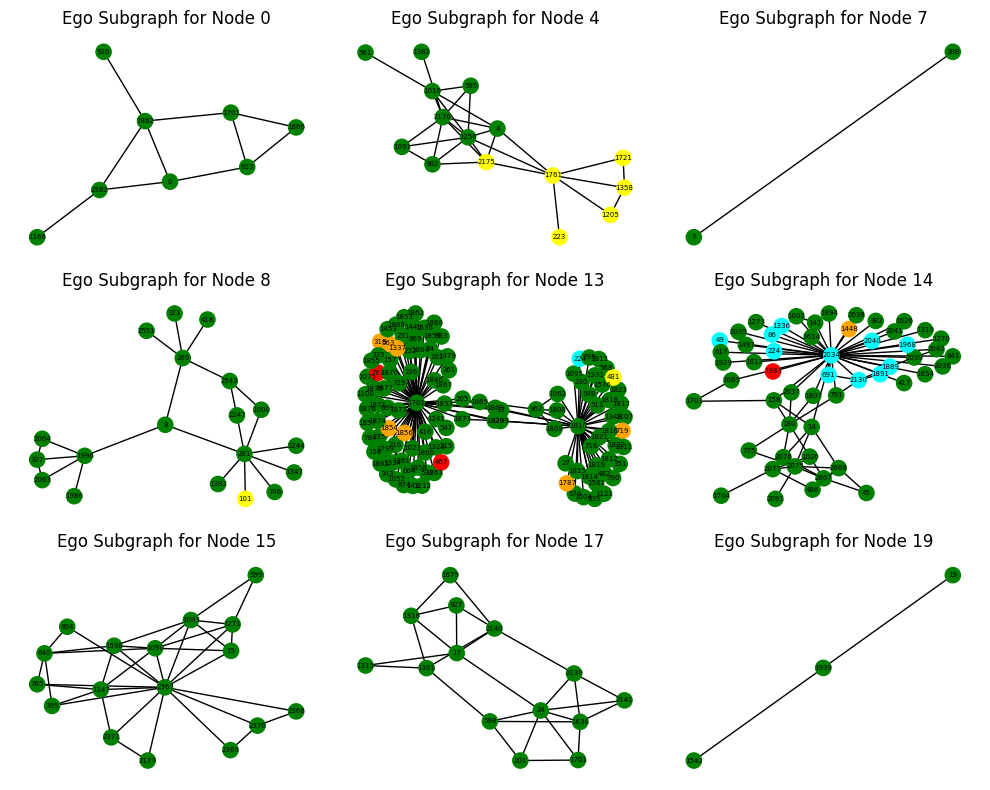

In [23]:
ego_plot(g, class3_l[:9], radius=2)

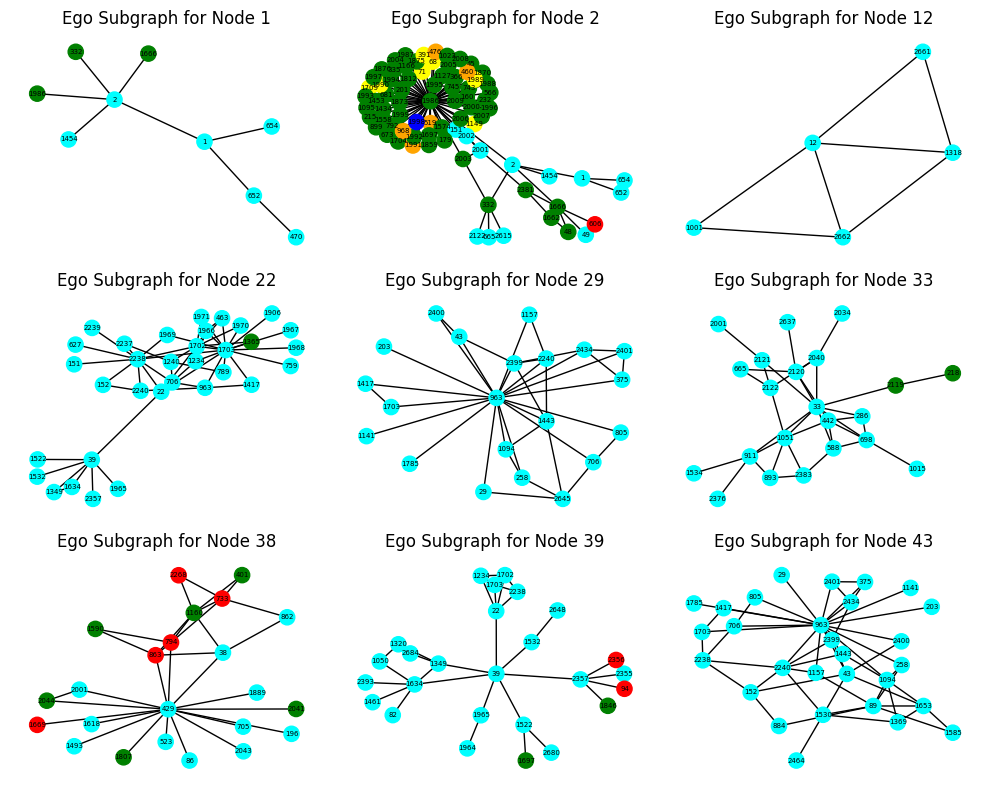

In [25]:
ego_plot(g, class4_l[:9], radius=2)

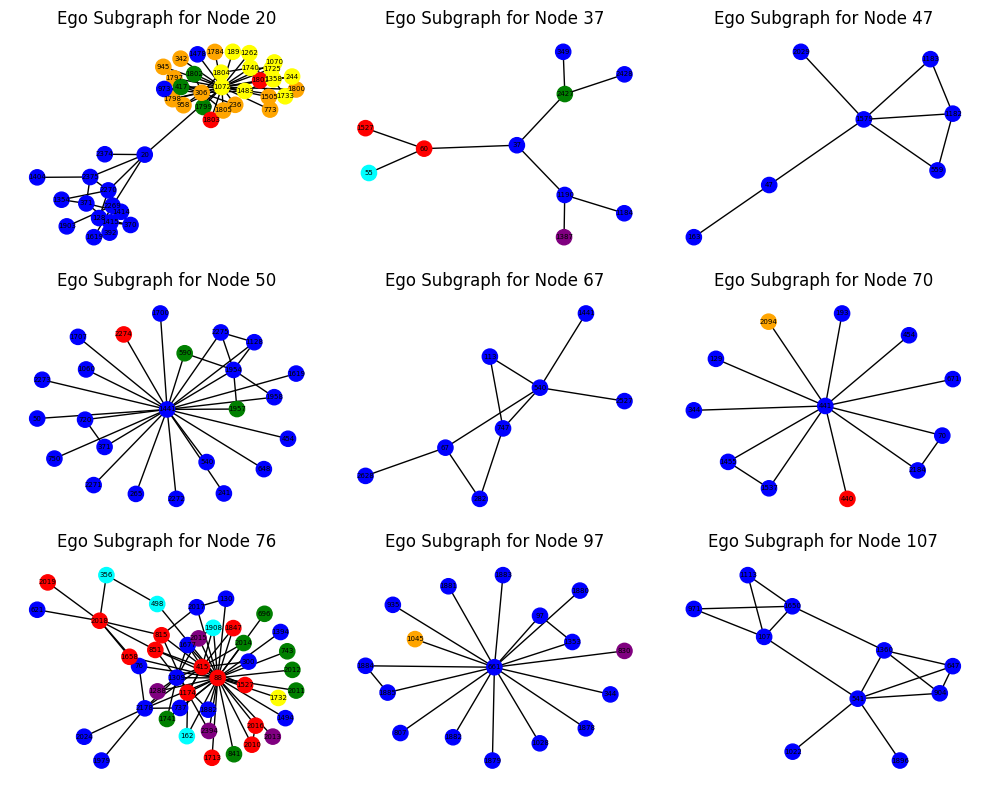

In [24]:
ego_plot(g, class5_l[:9], radius=2)

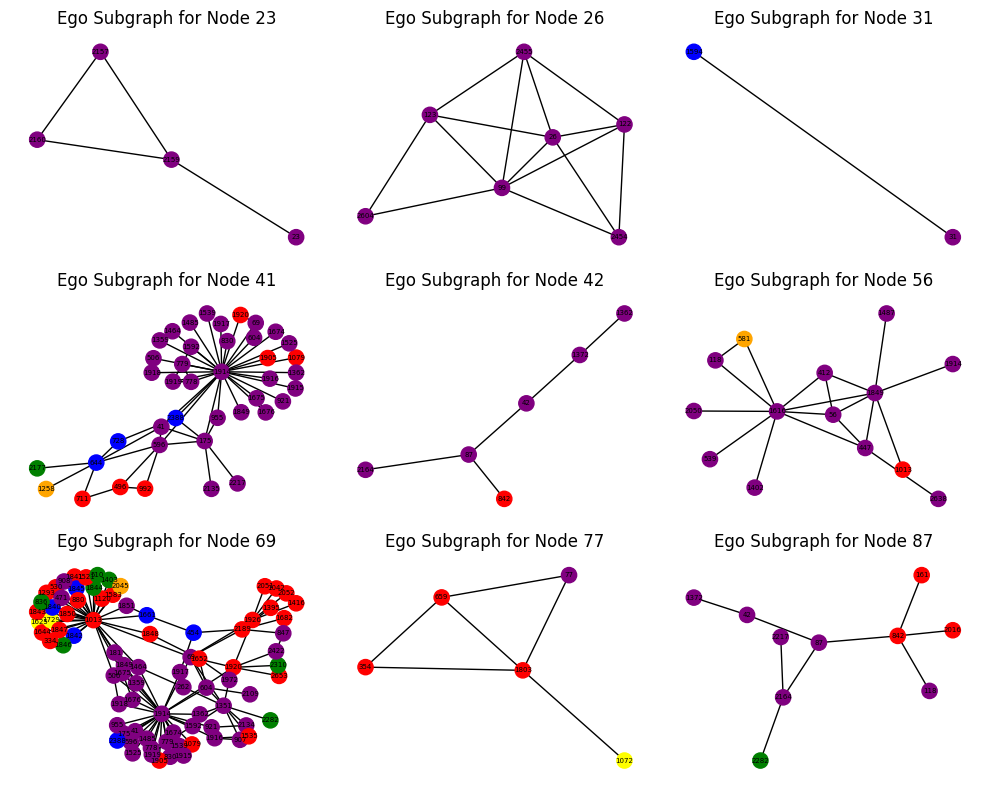

In [26]:
ego_plot(g, class6_l[:9], radius=2)

#### 节点属性分析

In [27]:
data.x.shape

torch.Size([2708, 1433])

#### GCN model

In [28]:
from typing import Union

from torch import Tensor
from torch_sparse import SparseTensor
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

'''
此模型邻居矩阵采用sparse tensor的形式，可以大大减少计算量，
如果不使用sparse tensor形式传递，将adj_t替换成edge_index
'''
class GCN(torch.nn.Module):
    def __init__(self
                 , in_channels
                 , hidden_channels
                 , out_channels
                 , num_layers
                 , dropout
                 , batchnorm=True):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels, cached=True))
        self.batchnorm = batchnorm
        if self.batchnorm:
            self.bns = torch.nn.ModuleList()
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(
                GCNConv(hidden_channels, hidden_channels, cached=True))
            if self.batchnorm: 
                self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels, cached=True))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        if self.batchnorm:
            for bn in self.bns:
                bn.reset_parameters()

    def forward(self, x, edge_index: Union[Tensor, SparseTensor]):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            if self.batchnorm: 
                x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x.log_softmax(dim=-1)

In [29]:
from typing import Union

from torch import Tensor
from torch_sparse import SparseTensor
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class SAGE(torch.nn.Module):
    def __init__(self
                 , in_channels
                 , hidden_channels
                 , out_channels
                 , num_layers
                 , dropout
                 , batchnorm=True):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.bns = torch.nn.ModuleList()
        self.batchnorm = batchnorm
        if self.batchnorm:
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
            if self.batchnorm:
                self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        if self.batchnorm:
            for bn in self.bns:
                bn.reset_parameters()

    def forward(self, x, edge_index: Union[Tensor, SparseTensor]):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            if self.batchnorm: 
                x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x.log_softmax(dim=-1)
    

In [30]:
from typing import Union

from torch import Tensor
from torch_sparse import SparseTensor
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GATv2Conv

class GAT(torch.nn.Module):
    def __init__(self
                 , in_channels
                 , hidden_channels
                 , out_channels
                 , num_layers
                 , dropout
                 , layer_heads = []
                 , batchnorm=True):
        super(GAT, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(in_channels, hidden_channels, heads=layer_heads[0], concat=True))
        self.bns = torch.nn.ModuleList()
        self.batchnorm = batchnorm
        if self.batchnorm:
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels*layer_heads[0]))
        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hidden_channels*layer_heads[i-1], hidden_channels, heads=layer_heads[i], concat=True))
            if self.batchnorm:
                self.bns.append(torch.nn.BatchNorm1d(hidden_channels*layer_heads[i-1]))
        self.convs.append(GATConv(hidden_channels*layer_heads[num_layers-2]
                          , out_channels
                          , heads=layer_heads[num_layers-1]
                          , concat=False))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        if self.batchnorm:
            for bn in self.bns:
                bn.reset_parameters()

    def forward(self, x, edge_index: Union[Tensor, SparseTensor]):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            if self.batchnorm: 
                x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x.log_softmax(dim=-1)
    
    
    
    
class GATv2(torch.nn.Module):
    def __init__(self
                 , in_channels
                 , hidden_channels
                 , out_channels
                 , num_layers
                 , dropout
                 , layer_heads = []
                 , batchnorm=True):
        super(GATv2, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GATv2Conv(in_channels, hidden_channels, heads=layer_heads[0], concat=True))
        self.bns = torch.nn.ModuleList()
        self.batchnorm = batchnorm
        if self.batchnorm:
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels*layer_heads[0]))
        for _ in range(num_layers - 2):
            self.convs.append(GATv2Conv(hidden_channels*layer_heads[i-1], hidden_channels, heads=layer_heads[i], concat=True))
            if self.batchnorm:
                self.bns.append(torch.nn.BatchNorm1d(hidden_channels*layer_heads[i-1]))
        self.convs.append(GATv2Conv(hidden_channels*layer_heads[num_layers-2]
                          , out_channels
                          , heads=layer_heads[num_layers-1]
                          , concat=False))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        if self.batchnorm:
            for bn in self.bns:
                bn.reset_parameters()

    def forward(self, x, edge_index: Union[Tensor, SparseTensor]):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            if self.batchnorm: 
                x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x.log_softmax(dim=-1)

In [31]:
# dataset name: DGraphFin

from utils import DGraphFin
from utils.utils import prepare_folder
from utils.evaluator import Evaluator
from utils.tricks import Missvalues
from utils.tricks import Background
from utils.tricks import Structure
# from models import MLP, MLPLinear, GCN, SAGE, GAT, GATv2,RGCN
from logger import Logger

import argparse

import torch
import torch.nn.functional as F
import torch.nn as nn

import torch_geometric as tg
import torch_geometric.transforms as T

from torch_sparse import SparseTensor
from torch_geometric.utils import to_undirected
import pandas as pd
import numpy as np
import time
eval_metric = 'auc'


gcn_parameters = {'lr':0.01
              , 'num_layers':2
              , 'hidden_channels':64
              , 'dropout':0.0
              , 'batchnorm': False
              , 'l2':5e-7
             }

sage_parameters = {'lr':0.01
              , 'num_layers':2
              , 'hidden_channels':64
              , 'dropout':0
              , 'batchnorm': False
              , 'l2':5e-7
             }


def train(model, data, train_idx, optimizer, weight=None, no_conv=False,is_rgcn=False):
    # data.y is labels of shape (N, ) 
    model.train()

    optimizer.zero_grad()
    if no_conv:
        out = model(data.x[train_idx])
    else:
        if(is_rgcn):
            out = model(data.x, data.edge_index, data.edge_type)[train_idx]
        else:
            out = model(data.x, data.edge_index)[train_idx]
    # print('*'*50)
    # print(out.type, data.y.type(), train_idx.type(), weight.type())
    loss = F.nll_loss(out, data.y[train_idx],weight = weight)
    loss.backward()
    optimizer.step()

    return loss.item()


@torch.no_grad()
def test(model, data, split_idx, evaluator, no_conv=False,is_rgcn=True):
    # data.y is labels of shape (N, )
    model.eval()
    
    if no_conv:
        out = model(data.x)
    else:
        if(is_rgcn):
            out = model(data.x, data.edge_index, data.edge_type)
        else:
            out = model(data.x, data.edge_index)
        
    y_pred = out.exp()  # (N,num_classes)
    
    losses, eval_results = dict(), dict()
    for key in ['train', 'valid', 'test']:
        node_id = split_idx[key]
        losses[key] = F.nll_loss(out[node_id], data.y[node_id]).item()
        eval_results[key] = evaluator.eval(data.y[node_id], y_pred[node_id])
            
    return eval_results, losses, y_pred


In [32]:
device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
# device = torch.device('cpu')
dataset = DGraphFin(root='./dataset/', name='DGraphFin', transform=T.ToSparseTensor())

data = dataset[0]
data.edge_index = data.adj_t
data.adj_t = torch.cat([data.edge_index.coo()[0].view(1,-1),data.edge_index.coo()[1].view(1,-1)],dim=0)
data.edge_index = data.adj_t
structure = Structure('original')
data = structure.process(data)
data.adj_t = data.edge_index
data.adj_t = tg.utils.to_undirected(data.adj_t)
data.edge_index = data.adj_t
if dataset in ['DGraphFin']:
    x = data.x
    x = (x-x.mean(0))/x.std(0)
    data.x = x
if data.y.dim()==2:
    data.y = data.y.squeeze(1)        

nlabels = 2

model = 'gcn'

no_conv = False
if model in ['mlp']: no_conv = True 

missvalues = Missvalues('null')
data = missvalues.process(data)

data.edge_index = data.adj_t
BN = Background('null')
data = BN.process(data,0.1)
print(data)
split_idx = {'train':data.train_mask, 'valid':data.valid_mask, 'test':data.test_mask}

fold = 0
if split_idx['train'].dim()>1 and split_idx['train'].shape[1] >1:
    kfolds = True
    print('There are {} folds of splits'.format(split_idx['train'].shape[1]))
    split_idx['train'] = split_idx['train'][:, fold]
    split_idx['valid'] = split_idx['valid'][:, fold]
    split_idx['test'] = split_idx['test'][:, fold]
else:
    kfolds = False

split_idx = {'train':data.train_mask, 'valid':data.valid_mask, 'test':data.test_mask}

data = data.to(device)
train_idx = split_idx['train'].to(device)
    
result_dir = prepare_folder('DGrapgFin', model)
print('result_dir:', result_dir)



is_rgcn=False
if model == 'mlp':
    para_dict = mlp_parameters
    model_para = mlp_parameters.copy()
    model_para.pop('lr')
    model_para.pop('l2')
    model = MLP(in_channels = data.x.size(-1), out_channels = nlabels, **model_para).to(device)
if model == 'gcn':   
    para_dict = gcn_parameters
    model_para = gcn_parameters.copy()
    model_para.pop('lr')
    model_para.pop('l2')        
    model = GCN(in_channels = data.x.size(-1), out_channels = nlabels, **model_para).to(device)
if model == 'sage':        
    para_dict = sage_parameters
    model_para = sage_parameters.copy()
    model_para.pop('lr')
    model_para.pop('l2')        
    model = SAGE(in_channels = data.x.size(-1), out_channels = nlabels, **model_para).to(device)

print(f'Model {model} initialized')



Data(x=[3700550, 17], edge_attr=[4300999], y=[3700550], train_mask=[857899], valid_mask=[183862], test_mask=[183840], adj_t=[2, 7994520], edge_index=[2, 7994520])
result_dir: ./model_results/DGrapgFin/gcn
Model GCN(
  (convs): ModuleList(
    (0): GCNConv(17, 64)
    (1): GCNConv(64, 2)
  )
) initialized


In [35]:
evaluator = Evaluator(eval_metric)
logger = Logger(2)
weight = torch.tensor([1,50]).to(device).float()

for run in range(5):
    import gc
    gc.collect()
    print(sum(p.numel() for p in model.parameters()))

    model.reset_parameters()
    optimizer = torch.optim.Adam(model.parameters(), lr=para_dict['lr'], weight_decay=para_dict['l2'])
    best_valid = 0
    min_valid_loss = 1e8
    best_out = None
    
    time_ls = []
    starttime = time.time()
    for epoch in range(1, 200):
        starttime = time.time()
        loss = train(model, data, train_idx, optimizer, weight,no_conv,is_rgcn)
        
        endtime = time.time()
        time_ls.append(endtime-starttime)
        eval_results, losses, out = test(model, data, split_idx, evaluator,no_conv,is_rgcn)
        train_auc, valid_auc, test_auc = eval_results['train']['auc'], eval_results['valid']['auc'], eval_results['test']['auc']
        train_ap, valid_ap, test_ap = eval_results['train']['ap'], eval_results['valid']['ap'], eval_results['test']['ap']
                                                                                                
        train_loss, valid_loss, test_loss = losses['train'], losses['valid'], losses['test']
        
        
        if valid_loss < min_valid_loss:
            min_valid_loss = valid_loss
            best_out = out.cpu()
        
        
        if epoch % 10 == 0:
            print(f'Run: {run + 1:02d}, '
                        f'Epoch: {epoch:02d}, '
                        f'Loss: {loss:.4f}, '
                        f'Train AUC: {train_auc:.3f} '
                        f'Train AP: {train_ap:.3f} '
                        f'Valid AUC: {valid_auc:.3f} '
                        f'Valid AP: {valid_ap:.3f} '
                        f'Test AUC: { test_auc:.3f} '
                        f'Test AP: { test_ap:.3f} '
                        f'Train time(s): {np.mean(time_ls):.3f}')
            
            
            time_ls = []
        logger.add_result(run, [train_auc, valid_auc, test_auc])

    logger.print_statistics(run)

final_results = logger.print_statistics()
print('final_results:', final_results)
para_dict.update(final_results)
pd.DataFrame(para_dict, index=[model]).to_csv(result_dir+'/results.csv')

1282
Run: 01, Epoch: 10, Loss: 0.6215, Train AUC: 0.685 Train AP: 0.025 Valid AUC: 0.682 Valid AP: 0.025 Test AUC: 0.688 Test AP: 0.024 Train time(s): 16.885
Run: 01, Epoch: 20, Loss: 0.6086, Train AUC: 0.704 Train AP: 0.027 Valid AUC: 0.699 Valid AP: 0.027 Test AUC: 0.704 Test AP: 0.026 Train time(s): 16.884


#### GraphSage

In [ ]:
device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
# device = torch.device('cpu')
dataset = DGraphFin(root='./dataset/', name='DGraphFin', transform=T.ToSparseTensor())

data = dataset[0]
data.edge_index = data.adj_t
data.adj_t = torch.cat([data.edge_index.coo()[0].view(1,-1),data.edge_index.coo()[1].view(1,-1)],dim=0)
data.edge_index = data.adj_t
structure = Structure('original')
data = structure.process(data)
data.adj_t = data.edge_index
data.adj_t = tg.utils.to_undirected(data.adj_t)
data.edge_index = data.adj_t
if dataset in ['DGraphFin']:
    x = data.x
    x = (x-x.mean(0))/x.std(0)
    data.x = x
if data.y.dim()==2:
    data.y = data.y.squeeze(1)        

nlabels = 2

model = 'sage'

no_conv = False
if model in ['mlp']: no_conv = True 

missvalues = Missvalues('null')
data = missvalues.process(data)

data.edge_index = data.adj_t
BN = Background('null')
data = BN.process(data,0.1)
print(data)
split_idx = {'train':data.train_mask, 'valid':data.valid_mask, 'test':data.test_mask}

fold = 0
if split_idx['train'].dim()>1 and split_idx['train'].shape[1] >1:
    kfolds = True
    print('There are {} folds of splits'.format(split_idx['train'].shape[1]))
    split_idx['train'] = split_idx['train'][:, fold]
    split_idx['valid'] = split_idx['valid'][:, fold]
    split_idx['test'] = split_idx['test'][:, fold]
else:
    kfolds = False

split_idx = {'train':data.train_mask, 'valid':data.valid_mask, 'test':data.test_mask}

data = data.to(device)
train_idx = split_idx['train'].to(device)
    
result_dir = prepare_folder('DGrapgFin', model)
print('result_dir:', result_dir)



is_rgcn=False
if model == 'gcn':   
    para_dict = gcn_parameters
    model_para = gcn_parameters.copy()
    model_para.pop('lr')
    model_para.pop('l2')        
    model = GCN(in_channels = data.x.size(-1), out_channels = nlabels, **model_para).to(device)
if model == 'sage':        
    para_dict = sage_parameters
    model_para = sage_parameters.copy()
    model_para.pop('lr')
    model_para.pop('l2')        
    model = SAGE(in_channels = data.x.size(-1), out_channels = nlabels, **model_para).to(device)
# if model == 'rgcn':   
#     para_dict = gcn_parameters
#     model = RGCN(data.x.size(-1),16,2,4).to(device)
#     is_rgcn=True
print(f'Model {model} initialized')



'torch.FloatTensor'

In [ ]:
evaluator = Evaluator(eval_metric)
logger = Logger(2)
weight = torch.tensor([1,50]).to(device).float()

for run in range(2):
    import gc
    gc.collect()
    print(sum(p.numel() for p in model.parameters()))

    model.reset_parameters()
    optimizer = torch.optim.Adam(model.parameters(), lr=para_dict['lr'], weight_decay=para_dict['l2'])
    best_valid = 0
    min_valid_loss = 1e8
    best_out = None
    
    time_ls = []
    starttime = time.time()
    for epoch in range(1, 200):
        starttime = time.time()
        loss = train(model, data, train_idx, optimizer, weight,no_conv,is_rgcn)
        
        endtime = time.time()
        time_ls.append(endtime-starttime)
        eval_results, losses, out = test(model, data, split_idx, evaluator,no_conv,is_rgcn)
        train_auc, valid_auc, test_auc = eval_results['train']['auc'], eval_results['valid']['auc'], eval_results['test']['auc']
        train_ap, valid_ap, test_ap = eval_results['train']['ap'], eval_results['valid']['ap'], eval_results['test']['ap']
                                                                                                
        train_loss, valid_loss, test_loss = losses['train'], losses['valid'], losses['test']
        #print(eval_results['train'])
#                 if valid_eval > best_valid:
#                     best_valid = valid_result
#                     best_out = out.cpu().exp()
        
        if valid_loss < min_valid_loss:
            min_valid_loss = valid_loss
            best_out = out.cpu()
        
        
        if epoch % 10 == 0:
            print(f'Run: {run + 1:02d}, '
                        f'Epoch: {epoch:02d}, '
                        f'Loss: {loss:.4f}, '
                        f'Train AUC: {train_auc:.3f} '
                        f'Train AP: {train_ap:.3f} '
                        f'Valid AUC: {valid_auc:.3f} '
                        f'Valid AP: {valid_ap:.3f} '
                        f'Test AUC: { test_auc:.3f} '
                        f'Test AP: { test_ap:.3f} '
                        f'Train time(s): {np.mean(time_ls):.3f}')
            
            
            time_ls = []
        logger.add_result(run, [train_auc, valid_auc, test_auc])

    logger.print_statistics(run)

final_results = logger.print_statistics()
print('final_results:', final_results)
para_dict.update(final_results)
pd.DataFrame(para_dict, index=[model]).to_csv(result_dir+'/sage_results.csv')

#### GAT

In [ ]:
device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
# device = torch.device('cpu')
dataset = DGraphFin(root='./dataset/', name='DGraphFin', transform=T.ToSparseTensor())

data = dataset[0]
data.edge_index = data.adj_t
data.adj_t = torch.cat([data.edge_index.coo()[0].view(1,-1),data.edge_index.coo()[1].view(1,-1)],dim=0)
data.edge_index = data.adj_t
structure = Structure('original')
data = structure.process(data)
data.adj_t = data.edge_index
data.adj_t = tg.utils.to_undirected(data.adj_t)
data.edge_index = data.adj_t
if dataset in ['DGraphFin']:
    x = data.x
    x = (x-x.mean(0))/x.std(0)
    data.x = x
if data.y.dim()==2:
    data.y = data.y.squeeze(1)        

nlabels = 2

model = 'gat'

no_conv = False
if model in ['mlp']: no_conv = True 

missvalues = Missvalues('null')
data = missvalues.process(data)

data.edge_index = data.adj_t
BN = Background('null')
data = BN.process(data,0.1)
print(data)
split_idx = {'train':data.train_mask, 'valid':data.valid_mask, 'test':data.test_mask}

fold = 0
if split_idx['train'].dim()>1 and split_idx['train'].shape[1] >1:
    kfolds = True
    print('There are {} folds of splits'.format(split_idx['train'].shape[1]))
    split_idx['train'] = split_idx['train'][:, fold]
    split_idx['valid'] = split_idx['valid'][:, fold]
    split_idx['test'] = split_idx['test'][:, fold]
else:
    kfolds = False

split_idx = {'train':data.train_mask, 'valid':data.valid_mask, 'test':data.test_mask}

data = data.to(device)
train_idx = split_idx['train'].to(device)
    
result_dir = prepare_folder('DGrapgFin', model)
print('result_dir:', result_dir)



is_rgcn=False
if model == 'mlp':
    para_dict = mlp_parameters
    model_para = mlp_parameters.copy()
    model_para.pop('lr')
    model_para.pop('l2')
    model = MLP(in_channels = data.x.size(-1), out_channels = nlabels, **model_para).to(device)
if model == 'gcn':   
    para_dict = gcn_parameters
    model_para = gcn_parameters.copy()
    model_para.pop('lr')
    model_para.pop('l2')        
    model = GCN(in_channels = data.x.size(-1), out_channels = nlabels, **model_para).to(device)
if model == 'sage':        
    para_dict = sage_parameters
    model_para = sage_parameters.copy()
    model_para.pop('lr')
    model_para.pop('l2')        
    model = SAGE(in_channels = data.x.size(-1), out_channels = nlabels, **model_para).to(device)
# if model == 'rgcn':   
#     para_dict = gcn_parameters
#     model = RGCN(data.x.size(-1),16,2,4).to(device)
#     is_rgcn=True
print(f'Model {model} initialized')



evaluator = Evaluator(eval_metric)
logger = Logger(2)
weight = torch.tensor([1,50]).to(device).float()

for run in range(2):
    import gc
    gc.collect()
    print(sum(p.numel() for p in model.parameters()))

    model.reset_parameters()
    optimizer = torch.optim.Adam(model.parameters(), lr=para_dict['lr'], weight_decay=para_dict['l2'])
    best_valid = 0
    min_valid_loss = 1e8
    best_out = None
    
    time_ls = []
    starttime = time.time()
    for epoch in range(1, 400):
        starttime = time.time()
        loss = train(model, data, train_idx, optimizer, weight,no_conv,is_rgcn)
        
        endtime = time.time()
        time_ls.append(endtime-starttime)
        eval_results, losses, out = test(model, data, split_idx, evaluator,no_conv,is_rgcn)
        train_auc, valid_auc, test_auc = eval_results['train']['auc'], eval_results['valid']['auc'], eval_results['test']['auc']
        train_ap, valid_ap, test_ap = eval_results['train']['ap'], eval_results['valid']['ap'], eval_results['test']['ap']
                                                                                                
        train_loss, valid_loss, test_loss = losses['train'], losses['valid'], losses['test']
        #print(eval_results['train'])
#                 if valid_eval > best_valid:
#                     best_valid = valid_result
#                     best_out = out.cpu().exp()
        
        if valid_loss < min_valid_loss:
            min_valid_loss = valid_loss
            best_out = out.cpu()
        
        
        if epoch % 10 == 0:
            print(f'Run: {run + 1:02d}, '
                        f'Epoch: {epoch:02d}, '
                        f'Loss: {loss:.4f}, '
                        f'Train AUC: {train_auc:.3f} '
                        f'Train AP: {train_ap:.3f} '
                        f'Valid AUC: {valid_auc:.3f} '
                        f'Valid AP: {valid_ap:.3f} '
                        f'Test AUC: { test_auc:.3f} '
                        f'Test AP: { test_ap:.3f} '
                        f'Train time(s): {np.mean(time_ls):.3f}')
            
            
            time_ls = []
        logger.add_result(run, [train_auc, valid_auc, test_auc])

    logger.print_statistics(run)

final_results = logger.print_statistics()
print('final_results:', final_results)
para_dict.update(final_results)
pd.DataFrame(para_dict, index=[model]).to_csv(result_dir+'/gat_results.csv')

#### 分析ego 3hop 节点属性相似性

In [165]:
cos = torch.nn.CosineSimilarity(dim=0)
output1 = cos(data.x[25,:], data.x[689540,:])
output2 = cos(data.x[25,:], data.x[2389637,:])
output3 = cos(data.x[25,:], data.x[1276331,:])
output4 = cos(data.x[2389637,:], data.x[1276331,:])

print(output1, output2, output3, output4)

tensor(-0.0008) tensor(0.9987) tensor(0.9977) tensor(0.9949)


In [167]:
def jaccard_sim(tensor1, tensor2):
    # 计算 Jaccard 相似性
    intersection = (tensor1 * tensor2).sum()
    union = (tensor1 + tensor2).clamp(0, 1).sum()
    jaccard_similarity = intersection / union

    print("Jaccard Similarity:", jaccard_similarity.item())

jaccard_sim(data.x[25,:], data.x[689540,:])
jaccard_sim(data.x[25,:], data.x[1386193,:])
jaccard_sim(data.x[25,:], data.x[2389637,:])
jaccard_sim(data.x[25,:], data.x[1276331,:])
jaccard_sim(data.x[2389637,:], data.x[1276331,:])

Jaccard Similarity: 0.15977278351783752
Jaccard Similarity: -1.867192509052984e-06
Jaccard Similarity: 0.02912781573832035
Jaccard Similarity: 0.029495764523744583
Jaccard Similarity: 0.014942402951419353


In [169]:
import numpy as np
from sklearn.decomposition import PCA

# 初始化PCA模型
pca = PCA()

# 拟合PCA模型
x_pca = pca.fit_transform(data.x.numpy())

# 计算累积方差解释比例
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# 选择保留的主成分数量
threshold = 0.95  # 选择一个累积比例的阈值
n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1

# 重新初始化PCA模型，指定保留的主成分数量
pca = PCA(n_components=n_components)
x_pca = pca.fit_transform(data.x.numpy())
x_pca

array([[-0.23705603],
       [-0.23707579],
       [-0.23707542],
       ...,
       [-0.23707578],
       [-0.23707578],
       [-0.23707578]], dtype=float32)

In [171]:
g

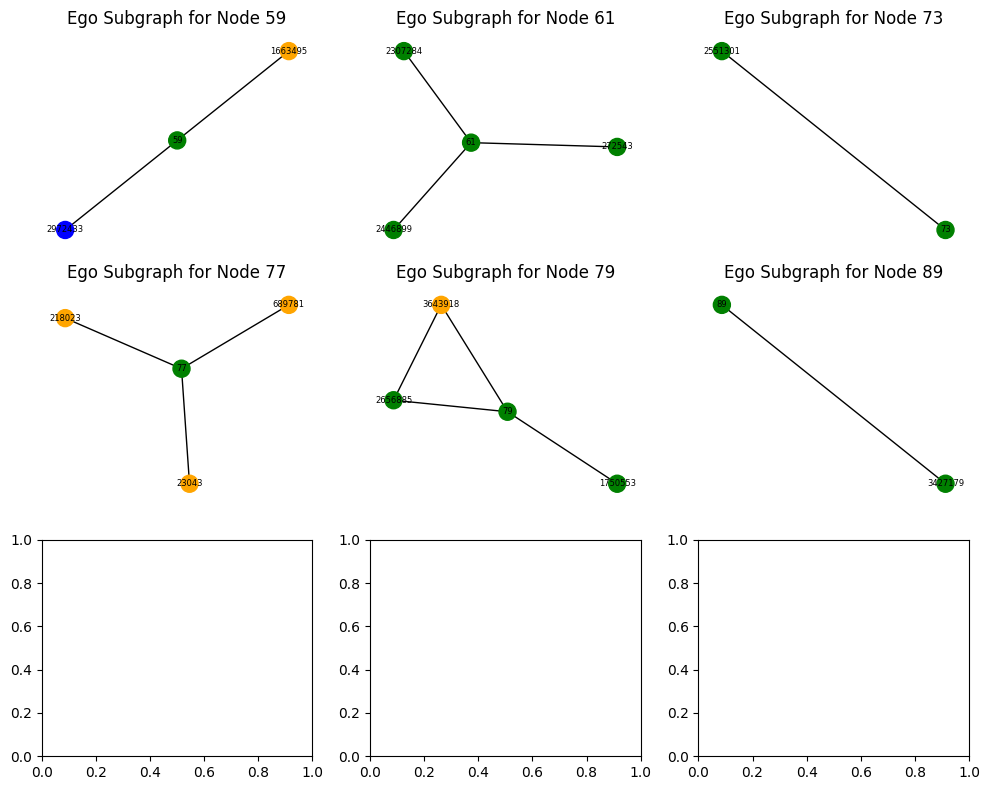

In [174]:
ego_plot(g, normal_l[10:16], radius=1)

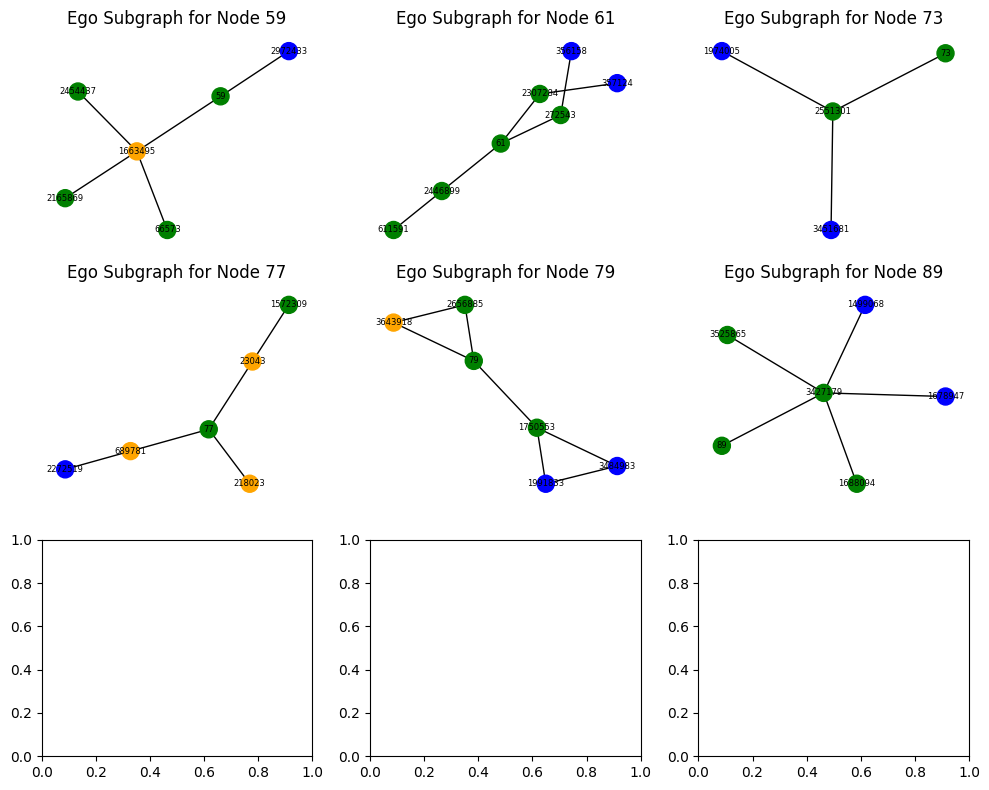

In [175]:
ego_plot(g, normal_l[10:16], radius=2)

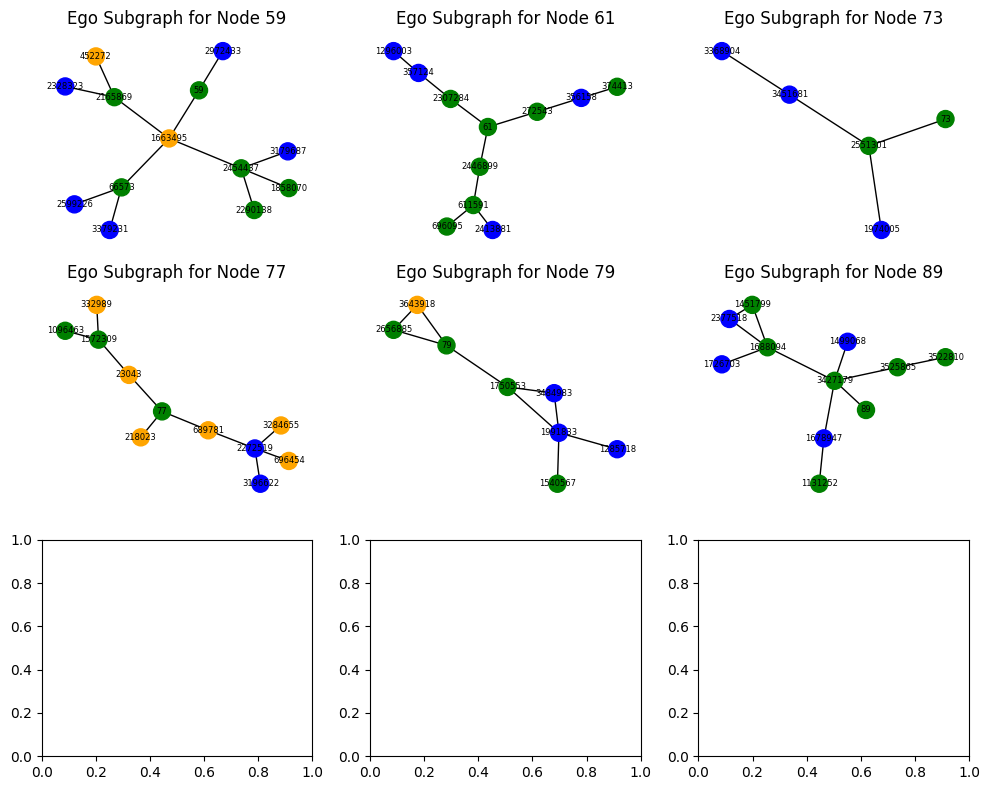

In [176]:
ego_plot(g, normal_l[10:16], radius=3)

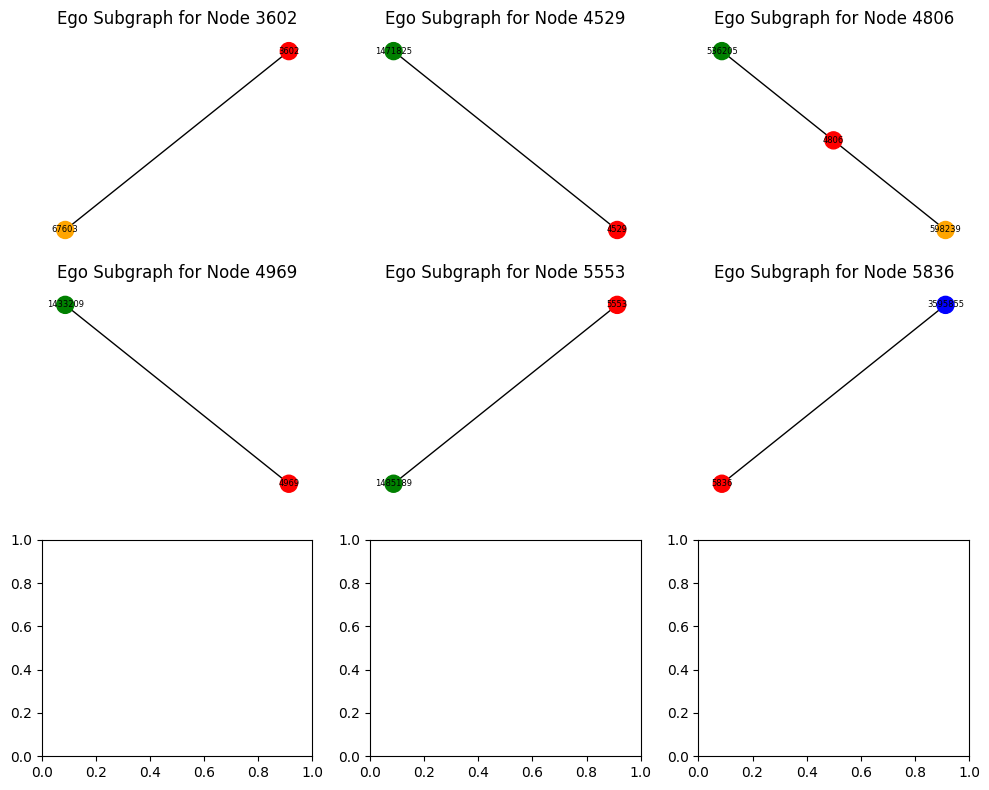

In [177]:
ego_plot(g, fraud_l[10:16], radius=1)

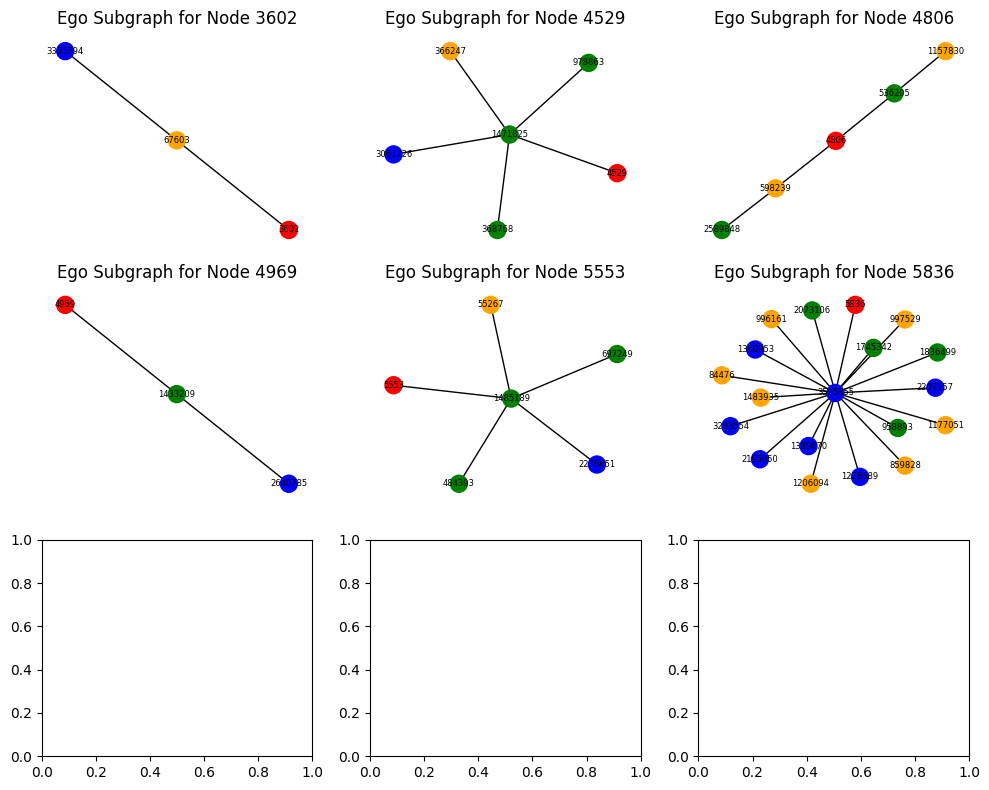

In [178]:
ego_plot(g, fraud_l[10:16], radius=2)

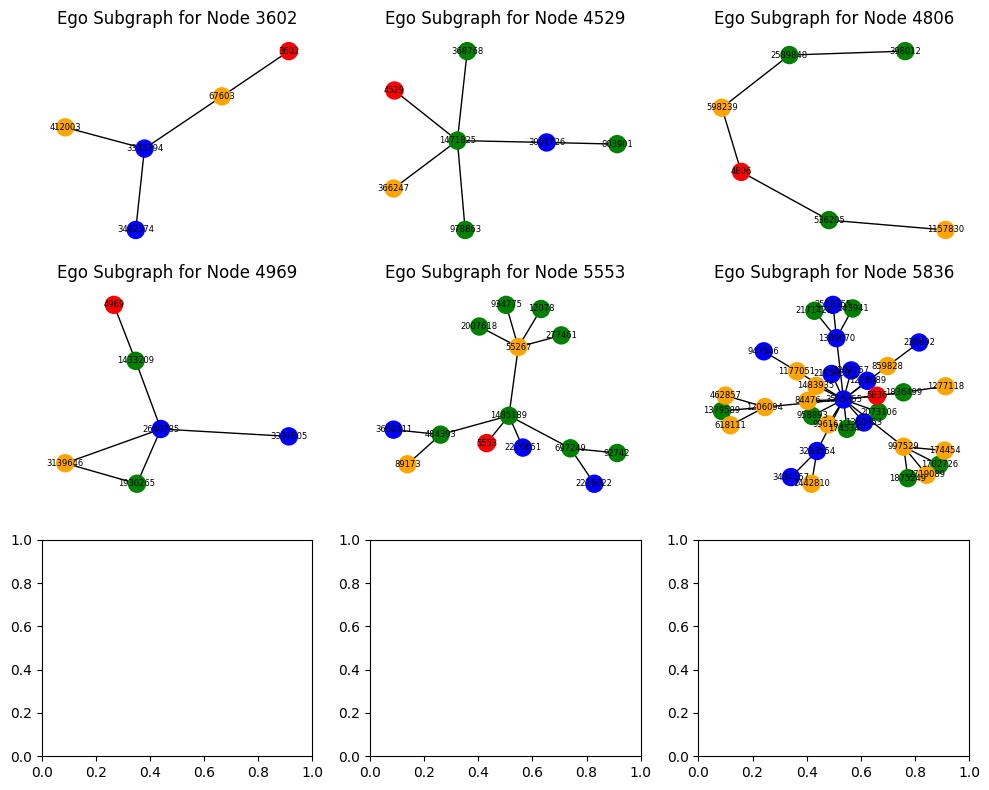

In [180]:
ego_plot(g, fraud_l[10:16], radius=3)